# Predictive modeling - An Example 

In this section we apply machine learning methods to a real world data set, the _adult_ data set. The data set is available on the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) and can be assessed and downloaded [here](https://archive.ics.uci.edu/ml/datasets/Adult).


For the purpose of this tutorial we already downloaded the data set. You may find it in the `datasets` folder (`../datasets/adult_data.txt`).

Please note that this tutorial bases on a talk given by [Olivier Grisel](https://github.com/ogrisel) and [Tim Head](https://github.com/betatim) at [EuroScipy 2017](https://www.euroscipy.org/2017/). You can watch their tutorial on YouTube ([Part I](https://www.youtube.com/watch?v=Vs7tdobwj1k&index=3&list=PL55N1lsytpbekFTO5swVmbHPhw093wo0h) and [Part II](https://www.youtube.com/watch?v=0eYOhEF_aK0&list=PL55N1lsytpbekFTO5swVmbHPhw093wo0h&index=2)).


**Import libraries**

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Global setting**

In [2]:
pd.options.display.max_columns = 200
plt.rcParams["figure.figsize"] = [12,6]

## The machine learning model development pipleline

<img src="./_img/ML_scheme.png" style="height: 500px;">

## Data preparation

### Load the data

In [3]:
filepath = "../datasets/adult_data.txt"
names = ("age, workclass, fnlwgt, education, education-num, "
         "marital-status, occupation, relationship, race, sex, "
         "capital-gain, capital-loss, hours-per-week, "
         "native-country, income").split(', ')    
data = pd.read_csv(filepath , names=names)

We take a look at the first rows of the data set by calling the `head()` function.

In [4]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Explore the data

A good advice before staring with any type of data analysis: __Know your data!__

Hence, we take a  look at the auxiliary data file `data_names.txt`.

In [5]:
! cat ../datasets/adult_names.txt

| This data was extracted from the census bureau database found at
| http://www.census.gov/ftp/pub/DES/www/welcome.html
| Donor: Ronny Kohavi and Barry Becker,
|        Data Mining and Visualization
|        Silicon Graphics.
|        e-mail: ronnyk@sgi.com for questions.
| Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).
| 48842 instances, mix of continuous and discrete    (train=32561, test=16281)
| 45222 if instances with unknown values are removed (train=30162, test=15060)
| Duplicate or conflicting instances : 6
| Class probabilities for adult.all file
| Probability for the label '>50K'  : 23.93% / 24.78% (without unknowns)
| Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)
|
| Extraction was done by Barry Becker from the 1994 Census database.  A set of
|   reasonably clean records was extracted using the following conditions:
|   ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
|
| Prediction task is to determine whether a person makes over

`fnlwgt` stands for "final weight". This is used by the Census Bureau to create "weighted tallies" of any specified socio-economic characteristics of the population. As we are no Census experts and don't know how to properly use that information, we delete the column.

In [6]:
data = data.drop('fnlwgt', axis=1)

> __The goal as stated in the auxiliary file is to predict whether a person makes over 50K $ a year.__

In [7]:
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456
std,13.640433,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [8]:
data.isnull().sum()

age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

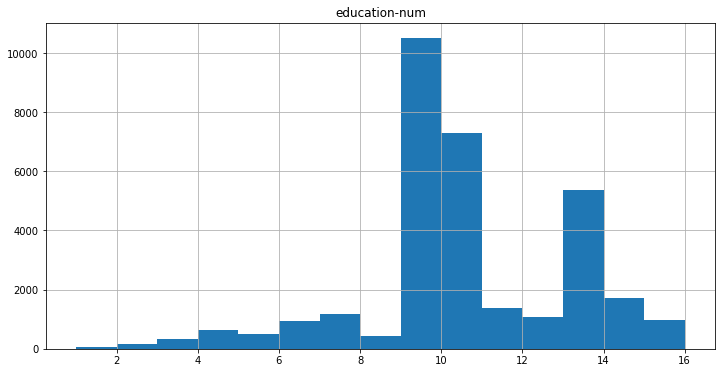

In [9]:
data.hist(column='education-num', bins=15);

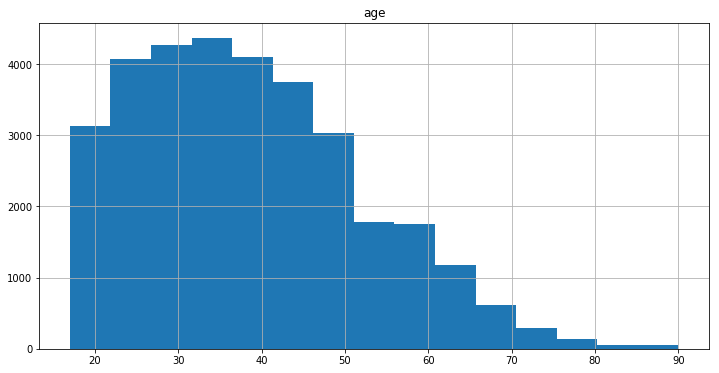

In [10]:
data.hist(column='age', bins=15);

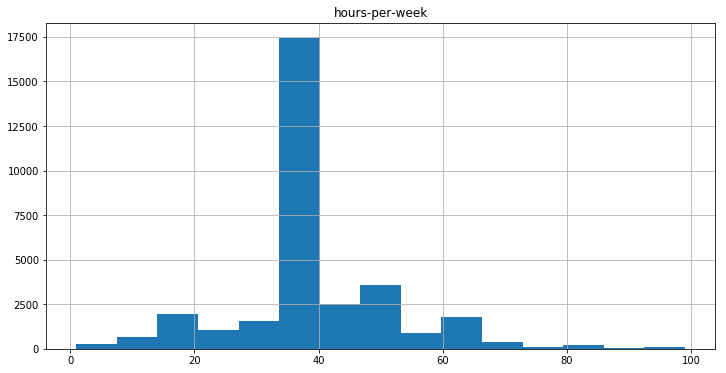

In [11]:
data.hist('hours-per-week', bins=15);

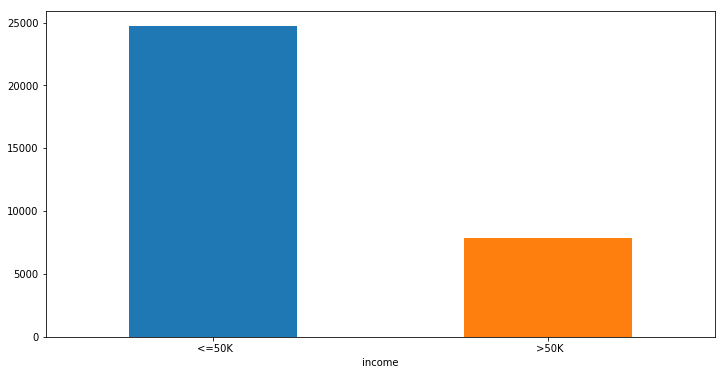

In [12]:
data.groupby('income')['income'].count().plot.bar(rot=0);

In [13]:
np.mean(data['income'] == ' >50K')

0.2408095574460244

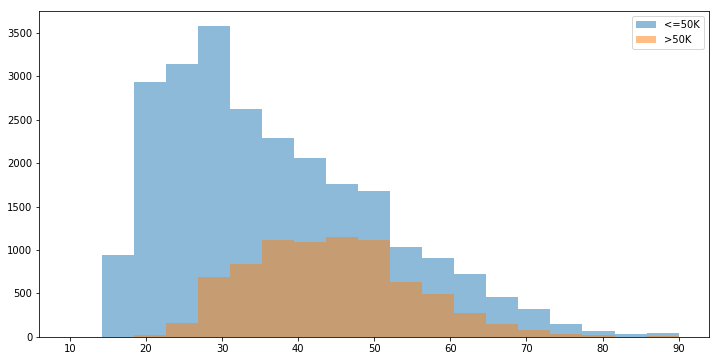

In [14]:
low_income = data[data['income'] == ' <=50K']
high_income = data[data['income'] == ' >50K']

bins = np.linspace(10, 90, 20)
plt.hist(low_income['age'].values, bins=bins, alpha=0.5, label='<=50K')
plt.hist(high_income['age'].values, bins=bins, alpha=0.5, label='>50K')
plt.legend(loc='best');

### Feature engineering

Split the data set into `target` and `feature` data sets.

In [15]:
target = data['income']
print("Target variable: ", target.shape)
features_data = data.drop('income', axis=1)
print("Features: ", features_data.shape)

Target variable:  (32561,)
Features:  (32561, 13)


#### Numerical features

In [16]:
numeric_features = [column_name for column_name in features_data
                    if features_data[column_name].dtype.kind in ('i', 'f')]
numeric_features

['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [17]:
numeric_data = features_data[numeric_features]
numeric_data.head(5)

,age,education-num,capital-gain,capital-loss,hours-per-week
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40
3,53,7,0,0,40
4,28,13,0,0,40


#### Categorical features

In [18]:
categorical_data = features_data.drop(numeric_features, axis=1)
categorical_data.head(5)

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba


In [19]:
categorical_data.describe()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
count,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,22696,10501,14976,4140,13193,27816,21790,29170


In [20]:
categorical_data_encoded = categorical_data.apply(lambda x: pd.factorize(x)[0])
categorical_data_encoded.head(5)

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,0,0,0,0,0,0,0,0
1,1,0,1,1,1,0,0,0
2,2,1,2,2,0,0,0,0
3,2,2,1,2,1,1,0,0
4,2,0,1,3,2,1,1,1


Alternatively we could have used use __one-hot encoding__ for categorical features calling `pd.get_dummies(features_data)`. 


In [21]:
pd.get_dummies(features_data).head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male,native-country_ ?,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,13,2174,0,40,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,50,13,0,0,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,38,9,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,53,7,0,0,40,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,28,13,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Combine numerical and categorical data**

In [22]:
features = pd.concat([numeric_data, categorical_data_encoded], axis=1)
features.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,39,13,2174,0,40,0,0,0,0,0,0,0,0
1,50,13,0,0,13,1,0,1,1,1,0,0,0
2,38,9,0,0,40,2,1,2,2,0,0,0,0
3,53,7,0,0,40,2,2,1,2,1,1,0,0
4,28,13,0,0,40,2,0,1,3,2,1,1,1


## Training-Test Split

In [23]:
X = features.values.astype(np.float32)
y = (target.values == ' >50K').astype(np.int32)

In [24]:
X.shape

(32561, 13)

In [25]:
y

array([0, 0, 0, ..., 0, 0, 1], dtype=int32)

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print("Training set: ", X_train.shape)
print("Test set: ", X_test.shape)

Training set:  (26048, 13)
Test set:  (6513, 13)


## Learning Algorithm - Decision Trees

[__Decision Trees__](https://en.wikipedia.org/wiki/Decision_tree_learning) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.


Some advantages of decision trees are:

* Simple to understand and to interpret (white box model). Trees can be visualized.
* Requires little data preparation.
* The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.
* Able to handle both numerical and categorical data. Other techniques are usually specialized in analyzing datasets that have only one type of variable. See algorithms for more information.

The disadvantages of decision trees include:

* Decision-tree learners can create over-complex trees that do not generalize the data well. This is called [overfitting](https://en.wikipedia.org/wiki/Overfitting). 

* Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.

In [27]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=8)

**Learning parameters on the train set**

In [28]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

**Predictions on the test set**

In [29]:
y_pred = clf.predict(X_test)
y_pred.shape

(6513,)

In [30]:
y_pred[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0], dtype=int32)

In [31]:
y_test[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1], dtype=int32)

## Model evaluation

A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), also known as an error matrix, is a special kind of contingency table, with two dimensions ("actual" and "predicted"), and identical sets of "classes" in both dimensions (each combination of dimension and class is a variable in the contingency table).

<img src="./_img/ConfusionMatrix.png" style="height: 400px;">

Source: [Harsha Pulletikurti](http://scaryscientist.blogspot.de/2016/03/confusion-matrix.html)

An informative blog post on performance metrics was recently published by [Andrew Long](https://towardsdatascience.com/data-science-performance-metrics-for-everyone-4d68f4859eef).

> **Challenge:** Compute the accuracy of the model on the test set (the average number of times the model predictions in `y_pred` match the true labels in `y_test`).

In [32]:
## your code here ...

In [33]:
# %load ../src/_solutions/accuracy.py
## the long way
print("The long way: ", (y_test==y_pred).sum()/len(y_test))

## the short way
from sklearn.metrics import accuracy_score
print("The short way: ", accuracy_score(y_true=y_test, y_pred=y_pred))

The long way:  0.8562874251497006
The short way:  0.8562874251497006


### Alternative performance metrics

Next to __accuary__, __precison__, __sensistivy__ and __specisgty__ there are quite some more performance metrics (for an overview visit  [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix)). One performance metric of particular interest is the [receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (ROC) curve.

The ROC curve is created by plotting the __true positive rate (TPR)__ (aka sensitivity) against the __false positive rate (FPR)__ (aka 1 − specificity) at various threshold settings. The ROC curve is generated by plotting the cumulative distribution function (__area under the probability distribution (AUC)__ from $-\infty$ to the discrimination threshold) of the detection probability in the y-axis versus the cumulative distribution function of the false-alarm probability on the x-axis.


In scikit-learn some classifiers offer the `predict_proba` method. This method is a (soft) classifier outputting the probability of the instance being in each of the classes.


In [34]:
predictions = clf.predict_proba(X_test)

In [35]:
predictions.shape

(6513, 2)

In [36]:
predictions[:5]

array([[0.97992278, 0.02007722],
       [0.68253968, 0.31746032],
       [0.27261688, 0.72738312],
       [0.98636364, 0.01363636],
       [0.91573034, 0.08426966]])

In [37]:
y_pred_proba = clf.predict_proba(X_test)[:, 1]
y_pred_proba[:5]

array([0.02007722, 0.31746032, 0.72738312, 0.01363636, 0.08426966])

In order to plot a __ROC curve__ we call the `roc_curve` function provided in the `sklearn.metrics` module. The __area under the curve (AUC)__ is computed by the `roc_auc_score` function.


In [38]:
from sklearn.metrics import roc_curve, roc_auc_score

In [39]:
auc = np.round(roc_auc_score(y_test, y_pred_proba),4)
print("ROC AUC: {}".format(auc))

ROC AUC: 0.9014


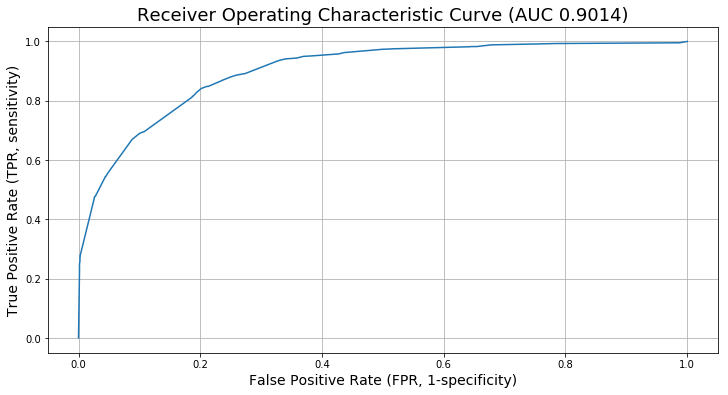

In [40]:
# compute FPR and TPR
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba)

# plot
fix, ax = plt.subplots()
ax.plot(fpr_dt, tpr_dt)
ax.set_ylabel("True Positive Rate (TPR, sensitivity)", size=14)
ax.set_xlabel("False Positive Rate (FPR, 1-specificity)", size=14)
ax.set_title("Receiver Operating Characteristic Curve (AUC {})".format(auc), size=18)
ax.grid();

## Cross-validation


### K-fold cross-validation (Source: [scikit-learn](http://scikit-learn.org/stable/modules/cross_validation.html))

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called __overfitting__. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set `X_test`, `y_test`. 

When evaluating different settings (__*hyperparameters*__) for estimators,there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called __“validation set”__: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called [__cross-validation__][1] (__CV__ for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called __k-fold CV__, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). 

The __performance measure reported by k-fold cross-validation is then the average of the values computed in the loop__. This approach can be computationally expensive, but does not waste too much data (as it is the case when fixing an arbitrary test set), which is a major advantage in problem such as inverse inference where the number of samples is very small.


![](./_img/K-fold_cross_validation_EN.png)

Source: [Wikipedia][1]

[1]: https://en.wikipedia.org/wiki/Cross-validation_(statistics)

In [41]:
from sklearn.model_selection import cross_validate

clf = DecisionTreeClassifier(max_depth=10)

results = cross_validate(clf, X_train, y_train, cv=5, scoring='roc_auc',
                         return_train_score=True)

In [42]:
results

{'fit_time': array([0.04389977, 0.03083396, 0.03141689, 0.03076291, 0.03046393]),
 'score_time': array([0.00218225, 0.00212407, 0.00211501, 0.00202513, 0.00201893]),
 'test_score': array([0.88719031, 0.8977058 , 0.89848531, 0.89445012, 0.89254341]),
 'train_score': array([0.92966376, 0.92832248, 0.92852521, 0.92830731, 0.92895744])}

In [43]:
print("ROC AUC Decision Tree (on validation folds): {:.4f} +/-{:.4f}".format(
    np.mean(results['test_score']), 
    np.std(results['test_score'])))

print("ROC AUC Decision Tree (on train folds): {:.4f} +/-{:.4f}".format(
    np.mean(results['train_score']), 
    np.std(results['train_score'])))

ROC AUC Decision Tree (on validation folds): 0.8941 +/-0.0041
ROC AUC Decision Tree (on train folds): 0.9288 +/-0.0005


> **Challenge**: Try different values of `max_depth` such as: `1`, `2`, `5`, `10`,`15`,... Can you suggest an explanation for the impact of `max_depth` on the cross-validate score?

## Learning Algorithm - Ensemble Learners

[Ensemble learning methods](https://en.wikipedia.org/wiki/Ensemble_learning) use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone. The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator. 


### Random Forests

[Random forests](https://en.wikipedia.org/wiki/Random_forest) are an ensemble learning method for classification and regression, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set. Random forests belong to the group of __averaging methods__. The driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.

In scikit-learn's [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) the ` n_estimators` controls the number of trees in the forest. The `max_features` parameter controls the size of the random subsets of features to consider when splitting a node. The `max_depth` parameter corresponds to the maximum depth of the tree.

In [44]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=30, max_features=10,
                             max_depth=10)
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [45]:
results = cross_validate(clf, X_train, y_train, cv=5, scoring='roc_auc',
                         n_jobs=-1, return_train_score=True)

print("ROC AUC Random Forest (on validation folds): {:.4f} +/-{:.4f}".format(
    np.mean(results['test_score']), 
    np.std(results['test_score'])))

print("ROC AUC Random Forest (on train folds): {:.4f} +/-{:.4f}".format(
    np.mean(results['train_score']), 
    np.std(results['train_score'])))

ROC AUC Random Forest (on validation folds): 0.9140 +/-0.0036
ROC AUC Random Forest (on train folds): 0.9365 +/-0.0007


### Gradient Boosting

[Gradient Tree Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) (GBT) is a generalization of boosting to arbitrary differentiable loss functions. GBT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems. 

The advantages of GBT are:

* Natural handling of data of mixed type (= heterogeneous features)
* Predictive power
* Robustness to outliers in output space (via robust loss functions)

In __boosting methods__, base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.

In scikit-learn's [`GradientBoostingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) implementation, the number of weak learners (i.e. regression trees) is controlled by the parameter `n_estimators`; The size of each tree can be controlled either by setting the tree depth via `max_depth` or by setting the number of leaf nodes via `max_leaf_nodes`. The `learning_rate` is a hyper-parameter in the range `(0.0, 1.0]` that controls overfitting via shrinkage.

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_leaf_nodes=5, learning_rate=0.1,
                                 n_estimators=100)
clf 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=5,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [47]:
results = cross_validate(clf, X_train, y_train, cv=5, scoring='roc_auc',
                         n_jobs=-1, return_train_score=True)

print("ROC AUC Gradient Boosted Trees (on validation folds): {:.4f} +/-{:.4f}".format(
    np.mean(results['test_score']), 
    np.std(results['test_score'])))

print("ROC AUC Gradient Boosted Trees (on train folds): {:.4f} +/-{:.4f}".format(
    np.mean(results['train_score']), 
    np.std(results['train_score'])))

ROC AUC Gradient Boosted Trees (on validation folds): 0.9181 +/-0.0024
ROC AUC Gradient Boosted Trees (on train folds): 0.9210 +/-0.0008


## Model comparison via model evaluation metrics

Note that we actually did not evaluate the model performance of the Random Forest Classifier nor the Gradient Boosting Classifier on a test set. Hence, we have to fit the model first using the `fit` method.

In [48]:
_ = clf.fit(X_train, y_train)

Now we may evaluate the model performance  on the test set. Once again we consider the [ROC AUC metric](https://de.wikipedia.org/wiki/Receiver_Operating_Characteristic).

In [49]:
from sklearn.metrics import roc_auc_score

y_pred_proba = clf.predict_proba(X_test)[:, 1]
print("ROC AUC for Gradient Boosting: {:0.4f}".format(roc_auc_score(y_test, y_pred_proba)))

ROC AUC for Gradient Boosting: 0.9213


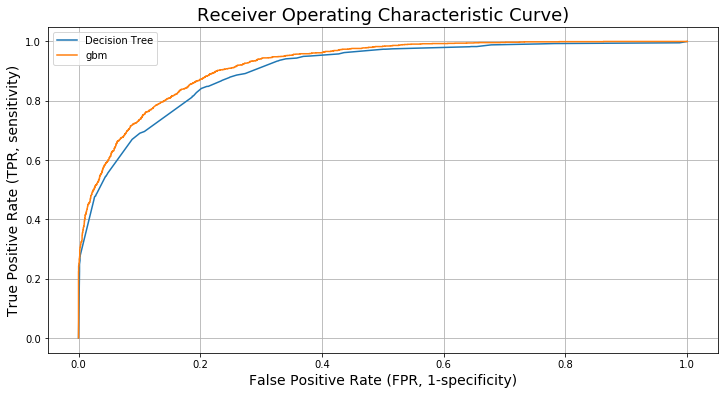

In [50]:
# compute FPR and TPR for gradient boosting model
fpr_gbm, tpr_gbm, _ = roc_curve(y_test, y_pred_proba)

# plot
fix, ax = plt.subplots()
ax.plot(fpr_dt, tpr_dt, label="Decision Tree")
ax.plot(fpr_gbm, tpr_gbm, label="gbm")
ax.set_ylabel("True Positive Rate (TPR, sensitivity)", size=14)
ax.set_xlabel("False Positive Rate (FPR, 1-specificity)", size=14)
ax.set_title("Receiver Operating Characteristic Curve)", size=18)
ax.legend()
ax.grid();

In [51]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=data['income'].unique()))

              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.92      4942
        >50K       0.80      0.60      0.68      1571

   micro avg       0.87      0.87      0.87      6513
   macro avg       0.84      0.78      0.80      6513
weighted avg       0.86      0.87      0.86      6513



## Variable importances


In [52]:
clf.feature_importances_

array([0.05887457, 0.18376541, 0.2908639 , 0.06622679, 0.04047703,
       0.00745577, 0.0010034 , 0.18399946, 0.02571086, 0.1361598 ,
       0.00050744, 0.00426528, 0.00069028])

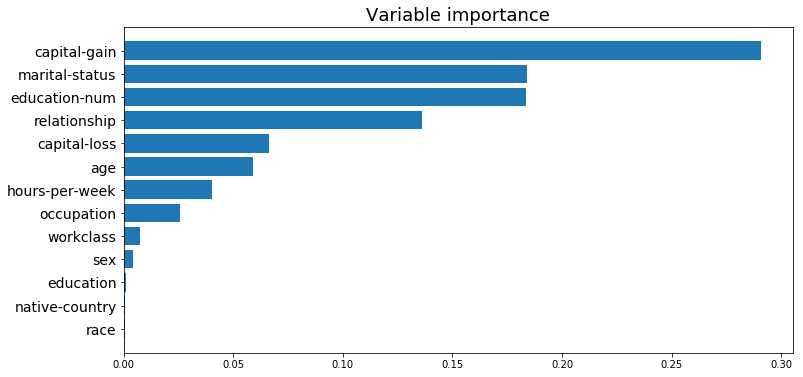

In [53]:
ordering = np.argsort(clf.feature_importances_)[::-1]

importances = clf.feature_importances_[ordering]
feature_names = features.columns[ordering]

fig, ax = plt.subplots()
y = np.arange(len(feature_names))
ax.barh(y,importances,align='center')
ax.invert_yaxis() 
ax.set_yticks(y)
ax.set_yticklabels(feature_names, size=14)
ax.set_title("Variable importance", size=18);